In [1]:
import torch
from torch.utils.data import DataLoader
from torch.optim import AdamW,SGD 

from datasets import load_dataset, load_metric

import matplotlib.pyplot as plt

import json


from transformers import AutoTokenizer

In [2]:
import dependency_model as dep

# Auxiliar

In [3]:
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
torch.manual_seed(27)

In [4]:
tokenizer = AutoTokenizer.from_pretrained("distilbert-base-uncased")

# Procesado datos train: ConvAI2

In [5]:
with open('Datasets\ConvAI2\convai_complete.json','r') as f:
    data = json.load(f)

In [6]:
# Utilizo convai2 para crear el vocabulario porque es el conjunto más grande de los usados
vocab = dep.Vocabulary(data,'relative')
convai_tokenized = dep.tokenize_dataset_with_dependencies(data,tokenizer,['to','as','about'],vocab)

# Procesado datos evaluación: md_gender

In [7]:
with open('Datasets\md_gender\md_complete.json','r',encoding="utf8") as f:
    md_data = json.load(f)

In [8]:
md_tokenized = dep.tokenize_dataset_with_dependencies(md_data,tokenizer,['to','as','about'],vocab)

# Creación dataloaders

In [9]:
convai_dataset = dep.CustomDataset(convai_tokenized,['to','as','about'],eval=False)
md_dataset = dep.CustomDataset(md_tokenized,['to','as','about'],eval=True)

dl_train =DataLoader(convai_dataset,batch_size=64,shuffle=True,collate_fn=dep.collate_fn)
dl_eval =DataLoader(md_dataset,batch_size=64,shuffle=False,collate_fn=dep.collate_fn)

# Modelo

In [10]:
# Parámetros
hidden_dim = 128
embedding_dim = 100
model_name = "distilbert-base-uncased"
num_labels = 3
tasks = ['to','as','about']

In [11]:
model = dep.MultiWithDependencies(model_name, num_labels,tasks,vocab,embedding_dim,lstm_hidden_dim=hidden_dim).to(device)

Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertModel: ['vocab_layer_norm.bias', 'vocab_layer_norm.weight', 'vocab_transform.weight', 'vocab_projector.bias', 'vocab_transform.bias', 'vocab_projector.weight']
- This IS expected if you are initializing DistilBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


  0%|          | 0/34410 [00:00<?, ?it/s]

100%|██████████| 34410/34410 [1:07:56<00:00,  8.71it/s]


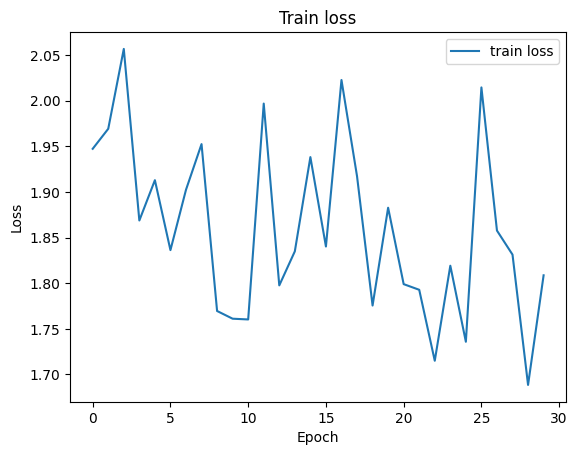

In [12]:

learning_rate = lr=5e-5
optimizer = AdamW(model.parameters(),learning_rate)
num_epochs = 30

train_loss = dep.train_function(model,num_epochs,dl_train,optimizer=optimizer)
torch.save(model.state_dict(),'distilbert_30_AW_D')

dep.plot_losses_train(train_loss)


In [13]:
metrics = ["accuracy","f1","precision","recall"]
for metric in metrics:
    print(metric)
    print(dep.eval_function_multi(model,dl_eval,tasks,metric))
    print('\n')

accuracy
{'to': {'accuracy': 0.726010101010101}, 'as': {'accuracy': 0.7222946544980443}, 'about': {'accuracy': 0.8214285714285714}}


f1
{'to': {'f1': 0.741973840665874}, 'as': {'f1': 0.7334167709637046}, 'about': {'f1': 0.8191214470284239}}


precision
{'to': {'precision': 0.7255813953488373}, 'as': {'precision': 0.7270471464019851}, 'about': {'precision': 0.8128205128205128}}


recall
{'to': {'recall': 0.7591240875912408}, 'as': {'recall': 0.73989898989899}, 'about': {'recall': 0.8255208333333334}}




Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertModel: ['vocab_layer_norm.bias', 'vocab_layer_norm.weight', 'vocab_transform.weight', 'vocab_projector.bias', 'vocab_transform.bias', 'vocab_projector.weight']
- This IS expected if you are initializing DistilBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


  0%|          | 0/34410 [00:00<?, ?it/s]

Epoch 1 	 Training loss: 2.011744737625122 
  3%|▎         | 1147/34410 [01:47<51:47, 10.70it/s]
Epoch 2 	 Training loss: 1.8475021123886108 
  7%|▋         | 2294/34410 [03:37<51:11, 10.46it/s]
Epoch 3 	 Training loss: 2.077029228210449 
 10%|█         | 3441/34410 [05:28<50:36, 10.20it/s]
Epoch 4 	 Training loss: 1.9891529083251953 
 13%|█▎        | 4588/34410 [07:25<52:33,  9.46it/s]
Epoch 5 	 Training loss: 2.020263195037842 
 17%|█▋        | 5735/34410 [09:21<48:36,  9.83it/s]
Epoch 6 	 Training loss: 2.016019344329834 
 20%|██        | 6882/34410 [11:17<50:17,  9.12it/s]
Epoch 7 	 Training loss: 2.140791416168213 
 23%|██▎       | 8029/34410 [13:13<45:29,  9.67it/s]
Epoch 8 	 Training loss: 1.9530959129333496 
 27%|██▋       | 9176/34410 [15:09<41:58, 10.02it/s]
Epoch 9 	 Training loss: 1.9822583198547363 
 30%|███       | 10323/34410 [17:07<41:01,  9.79it/s]
Epoch 10 	 Training loss: 1.9546388387680054 
 33%|███▎      | 11470/34410 [19:04<40:18,  9.49it/s]
Epoch 11 	 Training lo

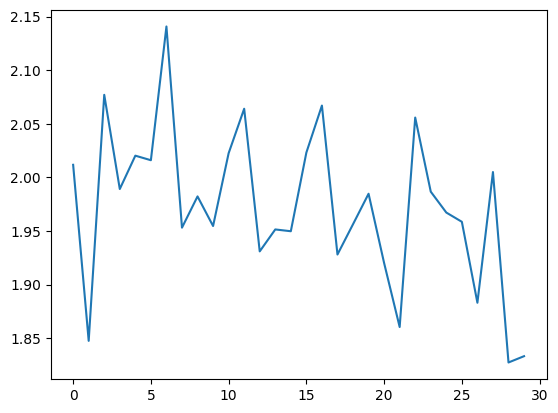

In [14]:
model = dep.MultiWithDependencies(model_name, num_labels,tasks,vocab,embedding_dim,lstm_hidden_dim=hidden_dim).to(device)




learning_rate = 5e-5
optimizer = SGD(model.parameters(), lr=learning_rate, momentum=0.9)
num_epochs = 30

train_loss= dep.train_function(model,num_epochs,dl_train,optimizer=optimizer)
torch.save(model.state_dict(),'distilbert_10_SGD_D')
plt.plot(train_loss)


In [ ]:
plot_losses_train(train_loss)

In [15]:
metrics = ["accuracy","f1","precision","recall"]
for metric in metrics:
    print(metric)
    print(dep.eval_function_multi(model,dl_eval,tasks,metric))
    print('\n')

accuracy
{'to': {'accuracy': 0.7272727272727273}, 'as': {'accuracy': 0.7235984354628422}, 'about': {'accuracy': 0.8482142857142857}}


f1
{'to': {'f1': 0.7365853658536585}, 'as': {'f1': 0.7232375979112272}, 'about': {'f1': 0.8436268068331143}}


precision
{'to': {'precision': 0.7383863080684596}, 'as': {'precision': 0.7486486486486487}, 'about': {'precision': 0.8514588859416445}}


recall
{'to': {'recall': 0.7347931873479319}, 'as': {'recall': 0.6994949494949495}, 'about': {'recall': 0.8359375}}


